# **Modelo de deteccion de estado de semaforos para ayudar a personas invidentes**

###INTEGRANTES

Cesar Enrique Rojas Hernandez - 2191952

Santiago Andres Delgado Quiceno - 211799

Mariana Robayo Nieto - 2195092

In [1]:
#@title Introduccion { display-mode: "form" }
from IPython.display import Image, display
url = "https://2.bp.blogspot.com/-Lz6hTiQT5LM/XCXD4kM7CqI/AAAAAAAACp4/\
gtenbm5odpQNPkaczgCJ8nMN8NJFF18iwCLcBGAs/s1600/jumilla-instalara-semaforos-para-invidentes.jpg"
display(Image(url=url))

El problema de autonomía para las personas invidentes al desplazarse por las calles radica en la falta de conciencia de los conductores y la dificultad para conocer el estado de los semáforos. Esto pone en riesgo su seguridad y limita su movilidad. Para abordar esta situación, se propone desarrollar un modelo de inteligencia artificial que aprenda a detectar el estado de los semáforos y proporcione indicaciones a las personas invidentes, permitiéndoles cruzar de manera más segura y autónoma.

In [2]:
#@title { display-mode: "form" }
!mkdir input/
!mkdir input/sartorius_cell_instance_segmentation
!kaggle datasets download -d santiagodelgado646/semaforos
!unzip /content/semaforos.zip
!rm /content/semaforos.zip
!rm /content/semaforos.zip

mkdir: cannot create directory ‘input/’: File exists
mkdir: cannot create directory ‘input/sartorius_cell_instance_segmentation’: File exists
Dataset URL: https://www.kaggle.com/datasets/santiagodelgado646/semaforos
License(s): MIT
 97% 200M/206M [00:03<00:00, 83.4MB/s]
100% 206M/206M [00:03<00:00, 69.4MB/s]
Archive:  /content/semaforos.zip
replace Semaforos rojos/rojo (1).jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: rm: cannot remove '/content/semaforos.zip': No such file or directory


In [21]:
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from tensorflow import keras
from sklearn.svm import SVC
import tensorflow as tf
from PIL import Image
import numpy as np
import time
import cv2
import os

In [22]:
red_dir = "Semaforos rojos"
green_dir = "Semaforos verdes"
img_size = (128, 128)  # Tamaño de imagen deseado

red_images_resized = []
for filename in tqdm(os.listdir(red_dir)):
    img = cv2.imread(os.path.join(red_dir, filename))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    resized_img = cv2.resize(img, img_size)
    red_images_resized.append(resized_img)

green_images_resized = []
for filename in tqdm(os.listdir(green_dir)):
    img = cv2.imread(os.path.join(green_dir, filename))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    resized_img = cv2.resize(img, img_size)
    green_images_resized.append(resized_img)


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/637 [00:00<?, ?it/s]

1209


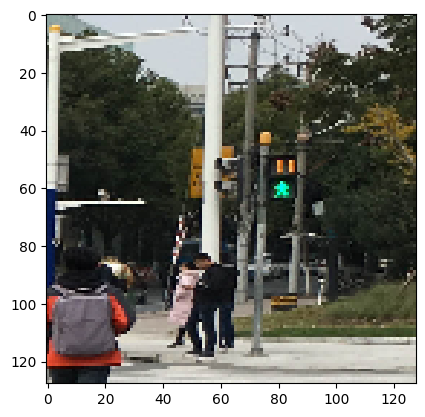

In [23]:
both = np.concatenate((red_images_resized, green_images_resized), axis=0)
index_red_image = np.random.randint(0, len(both)-1)
print(index_red_image)
plt.imshow(both[index_red_image], interpolation='nearest')
plt.show()

# **Generar imagenes "superpuestas"**

  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/637 [00:00<?, ?it/s]

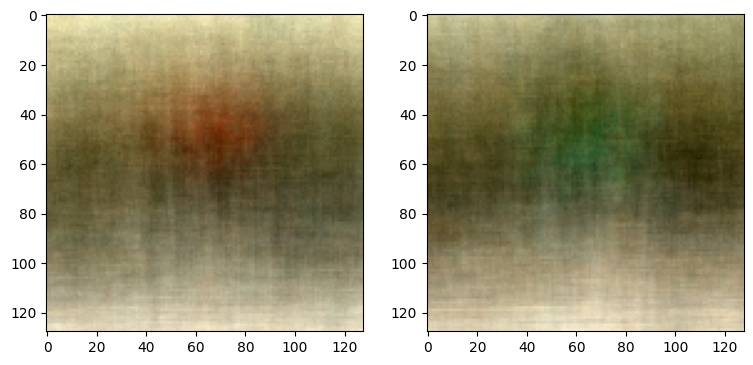

In [24]:
# @title Imagen promedio de muestras de semaforos rojos { display-mode: "form" }
# Superponer las imagenes una encima de la otra con una opacidad del 0.1
alpha = 0.1
average_red_img: np.ndarray = 0
average_green_img: np.ndarray = 0

for i in tqdm(red_images_resized):
  img = Image.fromarray(i)
  img_array = np.array(img)[:, :, :3]
  average_red_img += alpha * img_array

for i in tqdm(green_images_resized):
  img = Image.fromarray(i)
  img_array = np.array(img)[:, :, :3]
  average_green_img += alpha * img_array


def fix_avg_img(average_img: np.ndarray) -> np.ndarray:
  a = 255 / (average_img.max() - average_img.min())
  b = -a * average_img.min()
  average_img = (a * average_img + b).astype(np.uint8)
  return average_img

fig, axes = plt.subplots(1, 2, figsize=(9, 7))
axes[0].imshow(fix_avg_img(average_red_img))
axes[1].imshow(fix_avg_img(average_green_img))
plt.show()

# **Entrenamiento de estimadores**

In [26]:
# @title Listar datos { display-mode: "form" }
red_labels = np.zeros(len(red_images_resized))
green_labels = np.ones(len(green_images_resized))
y = np.concatenate((red_labels, green_labels), axis=0)
X = np.concatenate((red_images_resized, green_images_resized), axis=0)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1,
                                                    random_state=42,
                                                    shuffle=True)

X_train_norm = [(image - np.mean(image)) / np.std(image) for image in X_train]
X_test_norm = [(image - np.mean(image)) / np.std(image) for image in X_train]
flat_X_train = np.array(X_train_norm).reshape(len(X_train_norm), -1)
flat_X_test = np.array(X_test_norm).reshape(len(X_test_norm), -1)

In [ ]:
model = SVC(kernel= 'linear')
inicio = time.time()
model.fit(flat_X_train, y_train)
print(f"Precisión del clasificador '{model.__class__.__name__}':")
print(f"Tiempo: {time.time()-inicio}")
predictions = model.predict(flat_X_test)
print(classification_report(predictions, y_test))

Precisión del clasificador 'SVC':
Tiempo: 90.59847116470337


In [28]:
def graficar(numero_imagenes: int, predicciones, X_test, y_test):
  random_indices = np.random.choice(len(X_test), size=numero_imagenes**2, replace=False)
  # random_indices = np.random.choice(len(X_test), size=num_images, replace=False)

  # fig, axes = plt.subplots(1, num_images, figsize=(15, 10))
  fig, axes = plt.subplots(numero_imagenes, numero_imagenes, figsize=(15, 10))

  for i, index in enumerate(random_indices):
      image = X_test[index]
      prediction = predictions[index]
      label = y_test[index]

      title = 'Predicción: Verde' if prediction > 0.5 else 'Predicción: Rojo'
      title_color = 'green' if (prediction > 0.5 and label == 1) or (prediction <= 0.5 and label == 0) else 'red'

      ax = axes[i // numero_imagenes, i % numero_imagenes]
      # ax = axes[i]
      ax.imshow(image)
      ax.set_title(title, fontdict={"fontsize": 16}, color=title_color)
      ax.axis('off')

  plt.tight_layout()
  plt.show()

# **Test 1**

In [11]:
X = None
data_dir = None
filename = None
green_dir = None
green_images_normalized = None
green_images_resized = None
green_labels = None
img = None
img_size = None
indices = None
red_dir = None
red_images_normalized = None
red_images_resized = None
red_labels = None
resized_img = None
url = None
y = None

In [29]:
model = None
model = keras.Sequential([
    keras.layers.Rescaling(1./255, input_shape=X_train[0].shape),
    keras.layers.Conv2D(128, (4, 4), activation='relu'),
    keras.layers.MaxPooling2D((4, 4)),
    keras.layers.Conv2D(64, (3, 3), activation='relu'),
    keras.layers.MaxPooling2D((3, 3)),
    keras.layers.Conv2D(32, (2, 2), activation='relu'),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Flatten(),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy',
              metrics=['accuracy'])


In [30]:
model.fit(X_train, y_train, epochs=15, batch_size=16, validation_data=(X_test, y_test))

Epoch 1/15
72/72 [==============================] - 3s 20ms/step - loss: 0.6040 - accuracy: 0.6529 - val_loss: 0.7717 - val_accuracy: 0.6142
Epoch 2/15
72/72 [==============================] - 1s 14ms/step - loss: 0.2723 - accuracy: 0.8902 - val_loss: 0.0848 - val_accuracy: 0.9764
Epoch 3/15
72/72 [==============================] - 1s 13ms/step - loss: 0.1352 - accuracy: 0.9613 - val_loss: 0.0437 - val_accuracy: 0.9843
Epoch 4/15
72/72 [==============================] - 1s 12ms/step - loss: 0.1087 - accuracy: 0.9684 - val_loss: 0.0715 - val_accuracy: 0.9843
Epoch 5/15
72/72 [==============================] - 1s 13ms/step - loss: 0.0902 - accuracy: 0.9728 - val_loss: 0.0813 - val_accuracy: 0.9764
Epoch 6/15
72/72 [==============================] - 1s 12ms/step - loss: 0.0912 - accuracy: 0.9745 - val_loss: 0.0429 - val_accuracy: 0.9921
Epoch 7/15
72/72 [==============================] - 1s 13ms/step - loss: 0.0486 - accuracy: 0.9868 - val_loss: 0.0438 - val_accuracy: 0.9921
Epoch 8/15
72

4/4 [==============================] - 0s 8ms/step


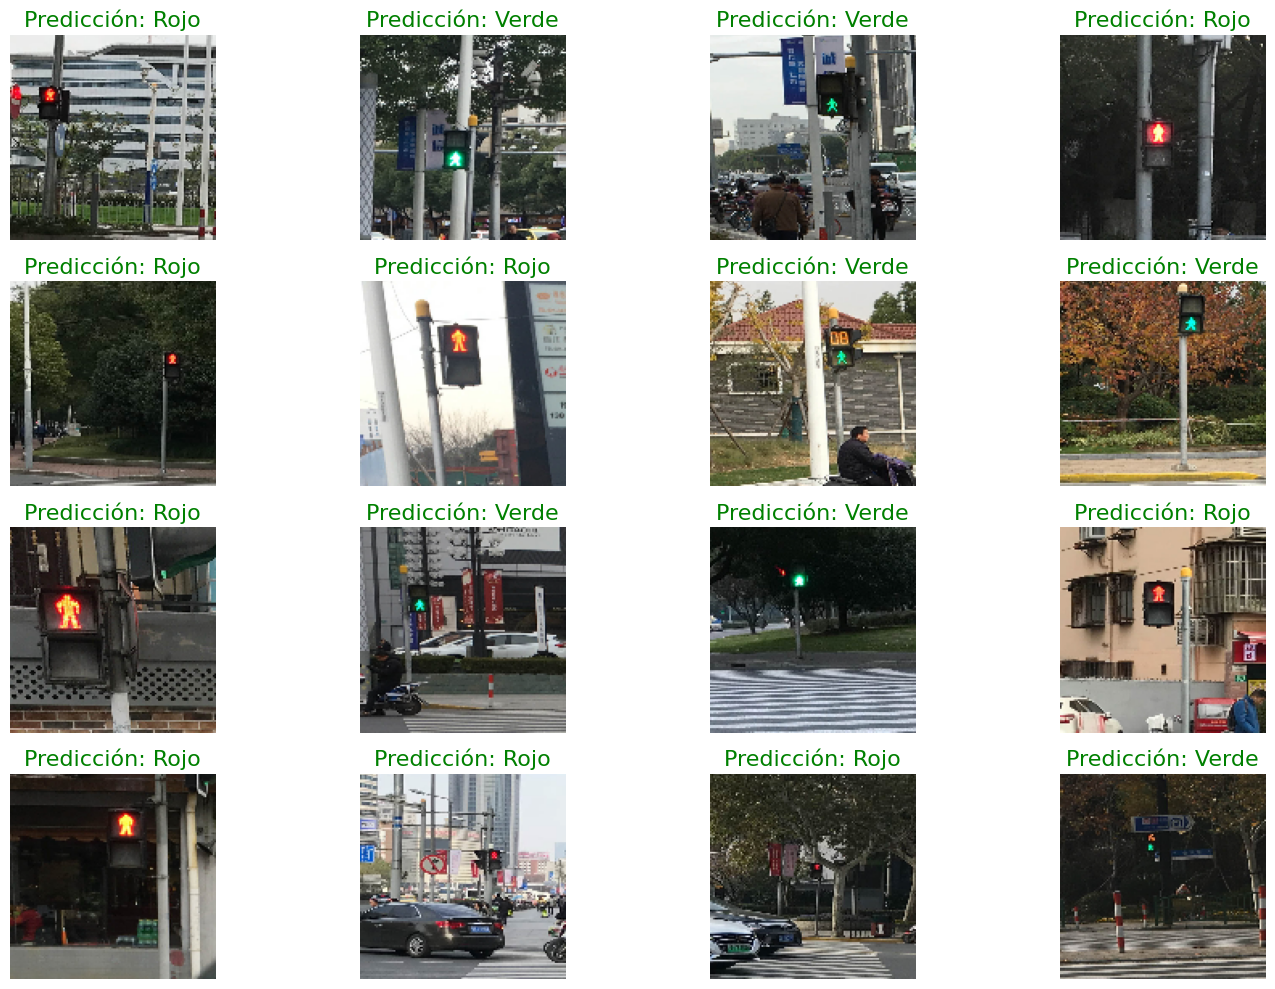

4/4 [==============================] - 0s 11ms/step - loss: 0.0942 - accuracy: 0.9606
Test accuracy: 0.960629940032959


In [31]:
predictions = model.predict(X_test)
graficar(4, predictions, X_test, y_test)
test_loss, test_acc = model.evaluate(X_test, y_test)
print('Test accuracy:', test_acc)